## Running OTVelo on real count matrices

This script shows how to run OTVelo on real data. First we load the necessary modules:

In [2]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import sys
import sklearn
sys.path.append('../Utils')
sys.path.append('..ata')
#import torch


from utils_Velo import *

from utils import *
import scipy
import matplotlib.pyplot as plt
#import test_batch_modules
#from test_batch_modules import batch_test, OT_lagged_correlation, load_others_result, batch_test_BEELINE, load_others_result_BEELINE
%load_ext autoreload
%autoreload 2

/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now we read the single-cell data from xlsx file and get all gene names. Note that the data is obtained from https://github.com/CABSEL/SINCERITIES. 

In [3]:
df = pd.read_excel('../Data/single_cell_kouno_data.xlsx')
gene_names_all = list(df.columns)
gene_names_all = gene_names_all[0:-2]
print(gene_names_all)

['BCL6', 'CBFB', 'CEBPB', 'CEBPD', 'EGR2', 'ELK1', 'ETS1', 'FLI1', 'FOS', 'FOSB', 'HOXA10', 'HOXA13', 'IRF8', 'JUN', 'KLF10', 'KLF13', 'LMO2', 'MAFB', 'MYB', 'MYEF2', 'NFATC1', 'NFATC2', 'NFE2L1', 'NFYA', 'NFYC', 'PPARD', 'PPARG', 'PRDM1', 'RREB1', 'RUNX1', 'RXRB', 'SMAD3', 'SMAD4', 'SNAI1', 'SNAI3', 'SP3', 'SPI1', 'SPIB', 'STAT1', 'TCF3', 'TCFL5', 'TFPT', 'TRIM28', 'UHRF1']


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


For performance evaluation metric, note that only a subnetwork of the following 20 genes is available:

In [4]:
idx_genes = [1 ,3,  4  ,   5  ,   8  ,  11  ,  12   , 13  ,  18  ,  19  ,  21  ,  23  ,  26   , 27  ,  28  ,  30  ,  35 ,41 ,   42 ,   44]
idx_genes = np.array(idx_genes) - 1
gene_names = []
for i in idx_genes:
    #print(i)
    gene_names = gene_names + [gene_names_all[i]]

Here we create labels and concatenate count matrices. As the data is already normalized, we directly take it as input. The group labels indicate the time stamps, which is not equispaced in this case:

In [5]:

counts = np.array(df)
counts = counts[:,0:-2]
counts = np.array(counts,dtype=float)
counts = counts.T

    
group_labels = [0,1,6,12,24,48,72,96]
Nt = len(group_labels)
stages = df.h
groups = [[]]*Nt



for j in range(len(group_labels)):
    groups[j] = []
    for i in range(len(stages)):
    
        if stages[i] == group_labels[j]:
            groups[j] += [i]
            
counts_all = [[0]]*Nt

labels = np.zeros((1,counts.shape[1]))
num_start = 0
for j in range(len(group_labels)):
    counts_all[j] = []
    counts_all[j] = np.array(counts[:,groups[j]],dtype=float)
    num_end = num_start + len(groups[j])
    
    labels[0,num_start:num_end] = j
    
    num_start = num_end

labels = labels[:,0:num_end]

counts = counts_all[0]
for j in range(Nt-1):
    counts = np.concatenate( (counts, counts_all[j+1] ), axis=1 )



Visualize the matrices. Top: all cells across all time points. Bottom: breakdown according to time.

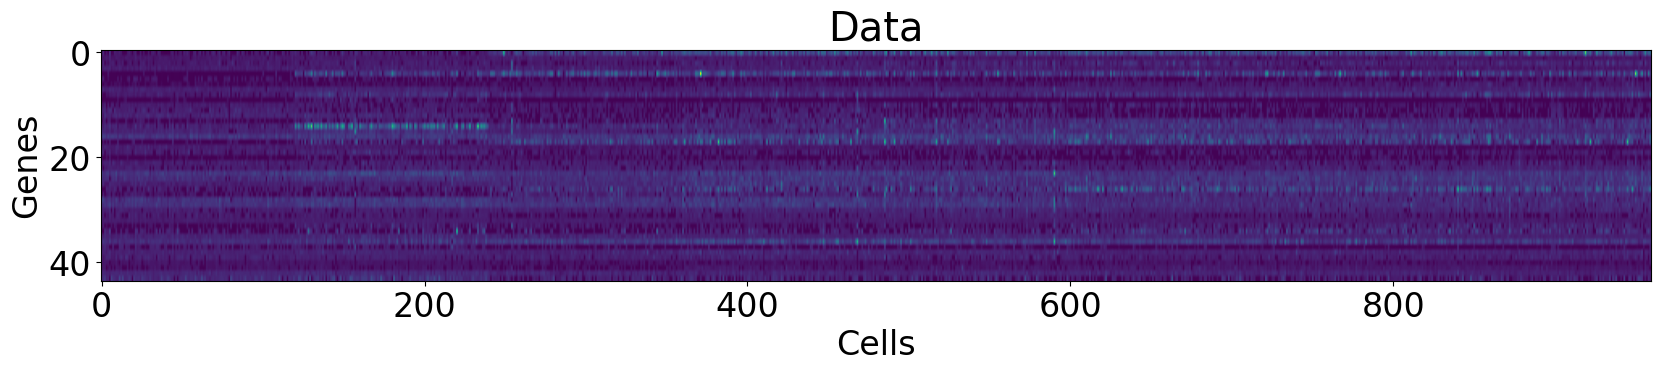

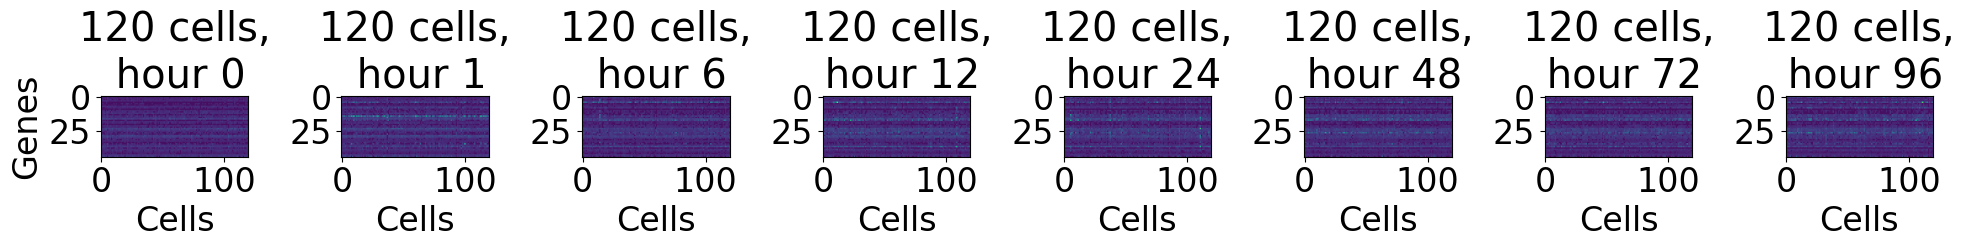

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["font.size"] = 24
plt.imshow(np.array(counts,dtype=float),aspect='auto' )
plt.title('Data')
plt.xlabel('Cells')
plt.ylabel('Genes')
plt.show()



for i in range(len(group_labels)):
    plt.subplot(1,Nt,i+1)
    plt.imshow(counts_all[i], aspect='auto')
    plt.title(str(counts_all[i].shape[1])+' cells,\n hour '+str(group_labels[i]) )
    plt.xlabel('Cells')
    if i == 0:
        plt.ylabel('Genes')
    plt.clim([0,counts.max()])
plt.tight_layout()
plt.show()

Here we compute PCA and visualize the first 2 PCs according to time:

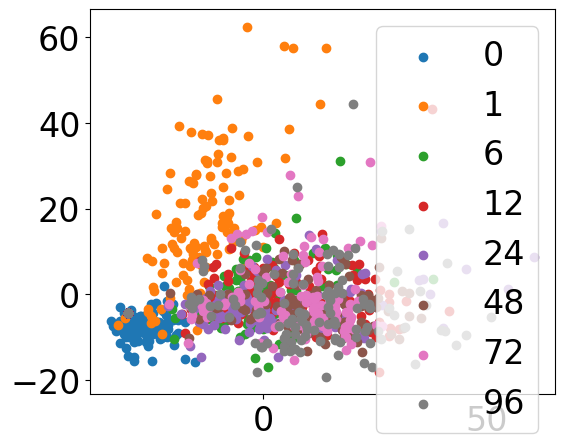

In [7]:
#plt.rcParams["figure.figsize"] = (8,5)
counts_pca,pca = visualize_pca(counts,labels,group_labels,viz_opt='pca')


plt.rcParams["figure.figsize"] = (6,5)
for i in range(Nt):
    idx = np.where( labels == i )
    plt.scatter( counts_pca[idx,0], counts_pca[idx,1], label=group_labels[i])
plt.legend()
plt.show()

First we perform trajectory inference via fGW:

In [8]:

eps_samp = 1e-2       
Ts_prior,_ = solve_prior(counts,counts, Nt, labels, eps_samp=eps_samp, alpha=0.5)


/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase t

Now compute velocities and visualize them according to genes:

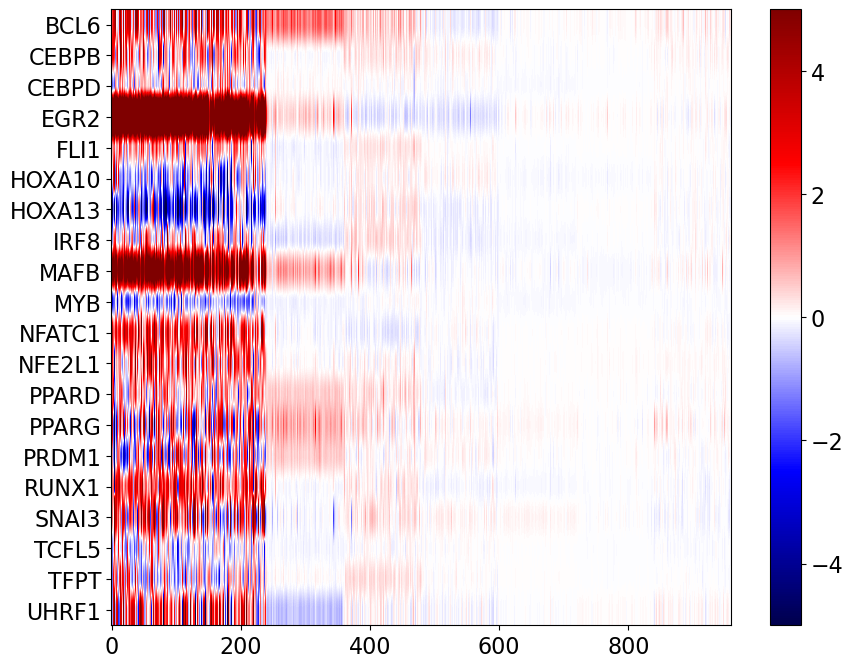

In [11]:
dt = [1,5,6,12,24,24,24] # time gaps
from utils_Velo import solve_velocities
velocities_all, velocities_all_signed = solve_velocities( counts_all, Ts_prior, dt=dt,order=1)

plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (5,5)
n = counts_all[0].shape[0]
velocities = np.zeros( (n, counts.shape[1]))
velocities_signed = np.zeros( (n, (counts.shape[1])))

s = []
for i in range(Nt):
    s = s + [counts_all[i].shape[1]]
s_cum = list(np.cumsum(s))
s_cum = [0] + s_cum

for i in range(Nt):
    
    velocities[:,s_cum[i]:s_cum[i+1] ] = velocities_all[i]
    velocities_signed[:,s_cum[i]:s_cum[i+1]] = velocities_all_signed[i]
    
plt.rcParams["figure.figsize"] = (10,8)
if velocities_signed.shape[0] == 44:
    plt.imshow( velocities_signed[idx_genes,:], aspect='auto',cmap='seismic')
    plt.yticks(range(len(idx_genes)),gene_names)
else:
    plt.imshow( velocities_signed, aspect='auto',cmap='seismic')
    plt.yticks(range(len(idx_genes)),gene_names)
plt.clim([-5,5])

plt.colorbar()
plt.show()    


Visualize the vector field of velocities in the space of first 2 PCs:

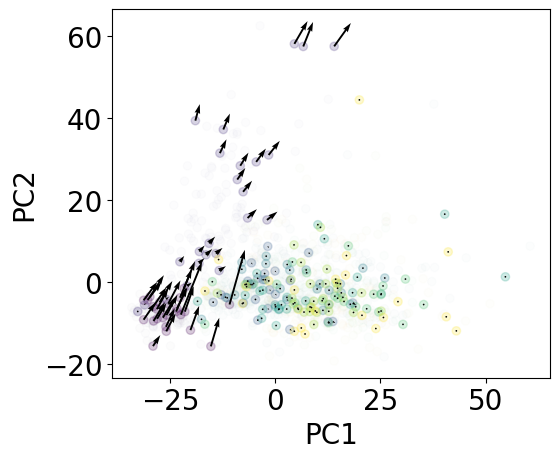

In [12]:
num_cells_per_step = 120
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["font.size"] = 20
velocities_all_pca = [ [0] ]*(Nt)
nums = []
for i in range(Nt):
    nums = nums + [ counts_all[i].shape[1] ]
      

i = 0
velocities_all_pca[i] = [0]
count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
    
velocities_all_pca[i] = (pca.transform( count_t_mapped.T ) - pca.transform( counts_all[i].T ))/dt[i]


for i in range(1,Nt-1):
    velocities_all_pca[i] = [0]
    count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
    
    velocities_all_pca[i] = pca.transform( count_t_mapped.T ) - pca.transform( counts_all[i].T )
    count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
    velocities_all_pca[i] = velocities_all_pca[i]/2/dt[i] + (pca.transform( counts_all[i].T ) - pca.transform( count_t_mapped.T ))/2/dt[i-1]
   
i = Nt-1

count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
velocities_all_pca[i] = ( pca.transform(counts_all[i].T) - pca.transform( count_t_mapped.T ) )/dt[i-1]

velocities_pca = np.zeros( (n, (Nt)*num_cells_per_step))

for i in range(Nt):
    
    velocities_pca[:,i*num_cells_per_step:(i+1)*num_cells_per_step] = velocities_all_pca[i].T

plt.scatter(counts_pca[:,0], counts_pca[:,1],c=labels, alpha=0.01 )
# plt.colorbar()
# velocities_pca = pca.transform( velocities_signed.T)
Num_cell = counts_pca.shape[0]
idx_subsamp = range(0,Num_cell,5)
plt.scatter(counts_pca[idx_subsamp,0], counts_pca[idx_subsamp,1],c=labels[0][idx_subsamp], alpha=0.2 )
plt.quiver( counts_pca[idx_subsamp,0],counts_pca[idx_subsamp,1],velocities_pca[0,idx_subsamp] , velocities_pca[1,idx_subsamp], scale=500 )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
#plt.savefig('../Results/Kouno/velocity_Kouno.pdf',dpi=1000)
plt.show()

Run `OTVelo-Corr` and `OTVelo-Granger` respectively:

In [13]:
Tv_corr = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, 
                                               stimulation=False)

In [14]:
Tv_Granger = OT_lagged_correlation(velocities_all_signed, velocities_signed, Ts_prior, signed=True, 
                              alpha_opt=1.0,elastic_Net=True, l1_opt=0.5, tune=False )

Now start to compare with truth for a 20 by 20 subnetwork.

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from evaluation_metrics import signed_AUPRC

if counts.shape[0] < 44:
    idx_genes = list( range( counts.shape[0]) )
else:
    idx_genes = [1 ,3,  4  ,   5  ,   8  ,  11  ,  12   , 13  ,  18  ,  19  ,  21  ,  23  ,  26   , 27  ,  28  ,  30  ,  35 ,41 ,   42 ,   44]
    idx_marker = list( np.array( idx_genes )-1 )
    idx_genes = idx_marker
idx = np.ix_(idx_marker, idx_marker)

In [23]:


import scipy.io
truth = scipy.io.loadmat('../Data/result_SINCERITIES_signed.mat')
truth = truth['adj_ref']

Tv_true_flattened = []
n = truth.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_true_flattened += [truth[i,j]]

Tv_true_flattened = np.array( Tv_true_flattened ) 


#sign = 'signed'
sign = None
option = 'corr'#


if option == 'EN':
    Tv_total = Tv_Granger

elif option == 'corr':
    Tv_total = Tv_corr

else:
    Tv_total = Tv_tune

Tv_total_small = Tv_total[ np.ix_(idx_genes,idx_genes)]
Tv_total_flattened = []

n = Tv_total_small.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:
            Tv_total_flattened += [Tv_total_small[i,j]]

Tv_total_flattened = np.array( Tv_total_flattened )
if sign == 'pos':
    Tv_total_flattened = Tv_total_flattened * (Tv_total_flattened>0)
    Tv_true_flattened = Tv_true_flattened * (Tv_true_flattened>0)
elif sign == 'neg':
    Tv_total_flattened = -Tv_total_flattened * (Tv_total_flattened<0)
    Tv_true_flattened = -Tv_true_flattened * (Tv_true_flattened<0)
elif sign == None:
    Tv_total_flattened = abs( np.array( Tv_total_flattened ) )
    Tv_true_flattened = abs( np.array( Tv_true_flattened ) )


if sign == None:
    precision, recall, _ = precision_recall_curve( Tv_true_flattened,Tv_total_flattened) 
    print('AUPRC='+str( auc( recall, precision) )  )
    print('AUROC='+str(roc_auc_score( abs(Tv_true_flattened), abs(Tv_total_flattened) ) ) )
else:
    auprc, auroc = signed_AUPRC( Tv_total_flattened, Tv_true_flattened)  
    print('AUPRC='+str( auprc ) )
    print('AUROC='+str( auroc ) )
# Tv_small_total[0] = Tv_small_total[0]/Tv_small_total[0].max()

#print( np.sum(np.array(Tv_total_flattened_signed)*np.array( Tv_true_flattened_signed)>0) )

AUPRC=0.29372262893596796
AUROC=0.5961067119155354


Visualize truth vs our matrix for closer comparison:

Text(0.5, 1.0, 'result')

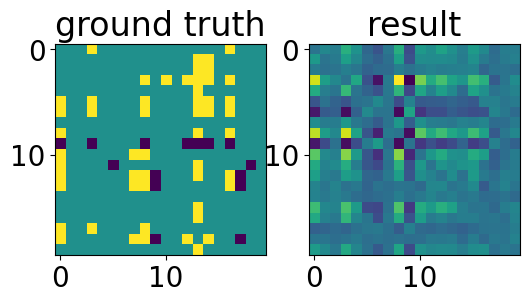

In [24]:
plt.subplot(1,2,1)
plt.imshow( truth )
plt.title('ground truth')
plt.subplot(1,2,2)
plt.imshow( Tv_total_small - np.diag( np.diag(Tv_total_small)) )
plt.title('result')
#plt.clim([-.5,.5])